In [3]:
# Deskriptive Statistik

# Testdaten löschen

import operator
from dateutil import parser
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
import json

In [5]:
# Synonyme für PFP als Liste
pfp_gen = ['Pflegefachperson', 'Pflegefachfrau', 'Pflegefachmann', 'Pflegefachkraft']
pfp_kh =  ['Krankenschwester', 'Krankenpfleger', 'Krankenpflegefachperson']
pfp_ap = ['Altenpfleger', 'Altenpflegefachkraft', 'Altenpflegefachperson']
pfp_ki = ['Kinderkrankenschwester', 'Kinderkrankenpfleger', 'Kinderkrankenpflegefachperson'] 
# Die Bezeichnungen in pfp_ki entsprechen den Bezeichnungen in pfp_kh mit dem Zusatz "Kinder".
# Falls in pfp_ki eine Bezeichnung steht, die dieser Regel widerspricht, so wird diese nicht gezählt!!
# Außerdem muss pfp_ki[n] auch pfp_kh[n] entsprechen (jeweils mit/ohne Kinder-), sonst funktioniert der Zähler nicht (Z. 142f.)!
# Dieser Regel darf also nicht widersprochen werden!
# Weibliche Formen, die nur durch -in entstehen, werden nicht beachtet bzw. zählen zu den männlichen dazu

In [9]:
#Testdaten
output = [
        {
            "date": "2020-08-01",
            "full_text": "abcAltenpflegerjhk"
            },
        {
            "date": "2024-06-07",
            "full_text": "123Altenpflegefachkraft123"
            },
        {
            "date": "2025-01-03",
            "full_text": "abcAltenpflegerinabc"
            },
        {
            "date": "2024-01-01",
            "full_text": "abcdPflegefachperson123"
            },
        {
            "date": "2025-07-04",
            "full_text": "123Krankenpflegerinabc"
            },
        {
            "date": "2025-01-01",
            "full_text": "abcd Pflegefachmann 123"
              },
        {
            "date": "2023-12-31",
            "full_text": "Krankenschwester12acde"
            },
        {
            "date": "2023-02-01",
            "full_text": "abcdPflegefachfrau74"
            },
        {
            "date": "2024-02-02",
            "full_text": "Krankenpflegerabcd"
            },
        {
            "date": "2024-03-02",
            "full_text": "aKinderkrankenpflegerb"}
        ]

In [37]:
read = sorted(output, key=lambda x: x["date"])
print('Insgesamt '+str(len(read))+' Stellenanzeigen gefunden')
print('Älteste Anzeige ist von '+read[0]["date"])
print('Neuste Anzeige ist von '+read[len(read)-1]["date"])

Insgesamt 10 Stellenanzeigen gefunden
Älteste Anzeige ist von 2020-08-01
Neuste Anzeige ist von 2025-07-04


In [39]:
# Verteilung plotten (x=Monat/Jahr, y=Anzahl Stellenanzeigen); zuerst: Monate, Jahre und Anzahlen pro Monat und Jahr extrahieren
timestamps = [datetime.strptime(item["date"], "%Y-%m-%d") for item in read]
months = sorted({(ts.year, ts.month) for ts in timestamps})
month_labels = [datetime(year, month, 1).strftime("%b %Y") for year, month in months]
month_counts = {month: 0 for month in months}
years = sorted({ts.year for ts in timestamps})
year_counts = {year: 0 for year in years}
for ts in timestamps:
    month_counts[(ts.year, ts.month)] += 1
    year_counts[ts.year] += 1

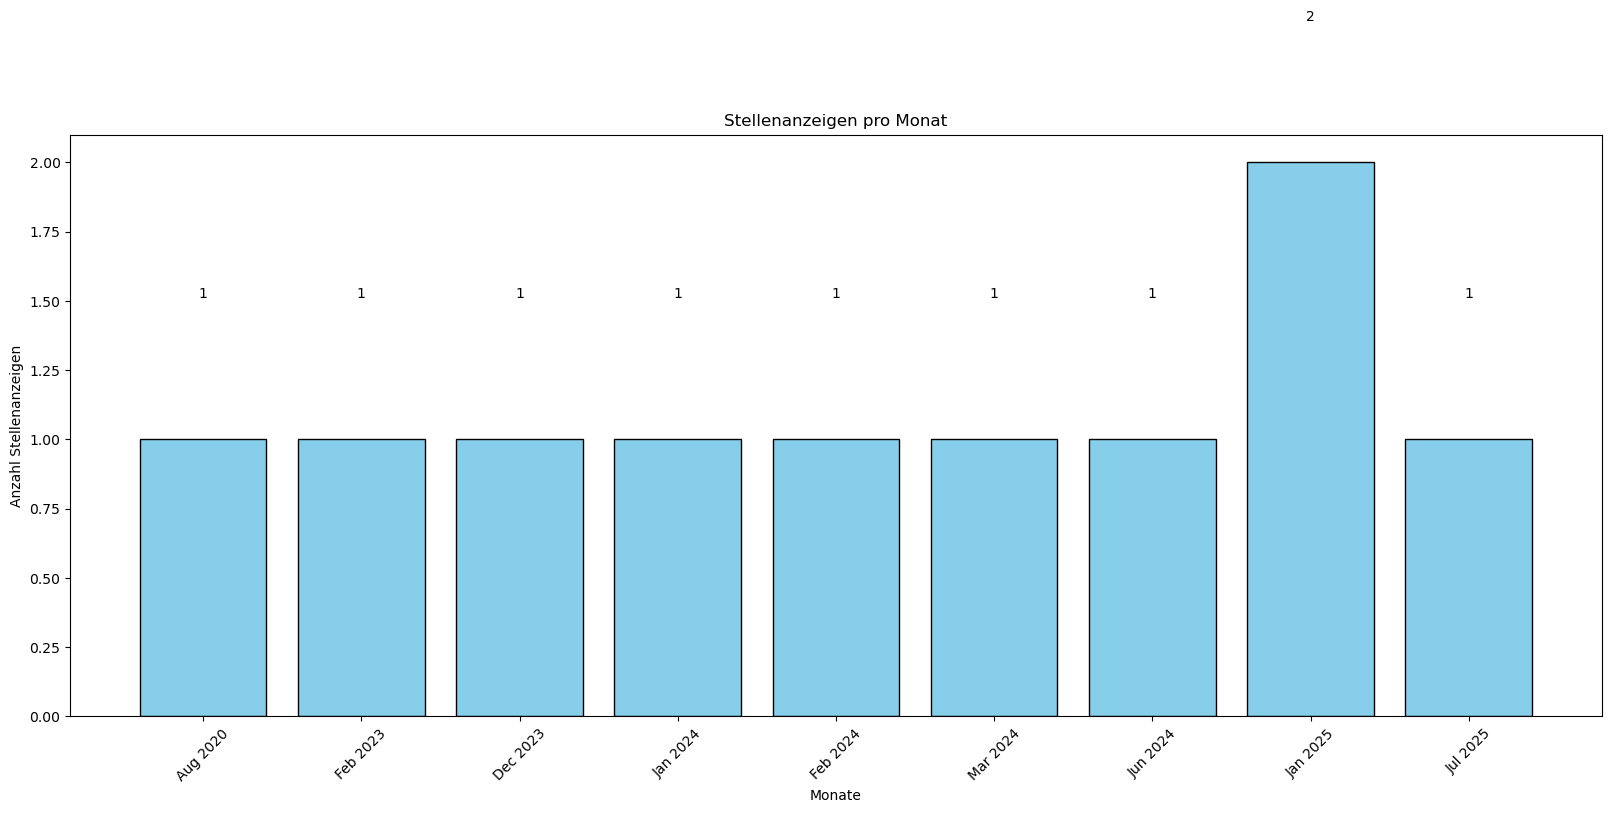

In [41]:
# Stellenanzeigen pro Monat
xmonths = np.arange(len(month_labels))
ymonths = [month_counts[month] for month in months]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
barone = ax.bar(xmonths, ymonths, color='skyblue', edgecolor='black')
for rect in barone:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), ha='center', va='bottom')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Monat')
plt.show()

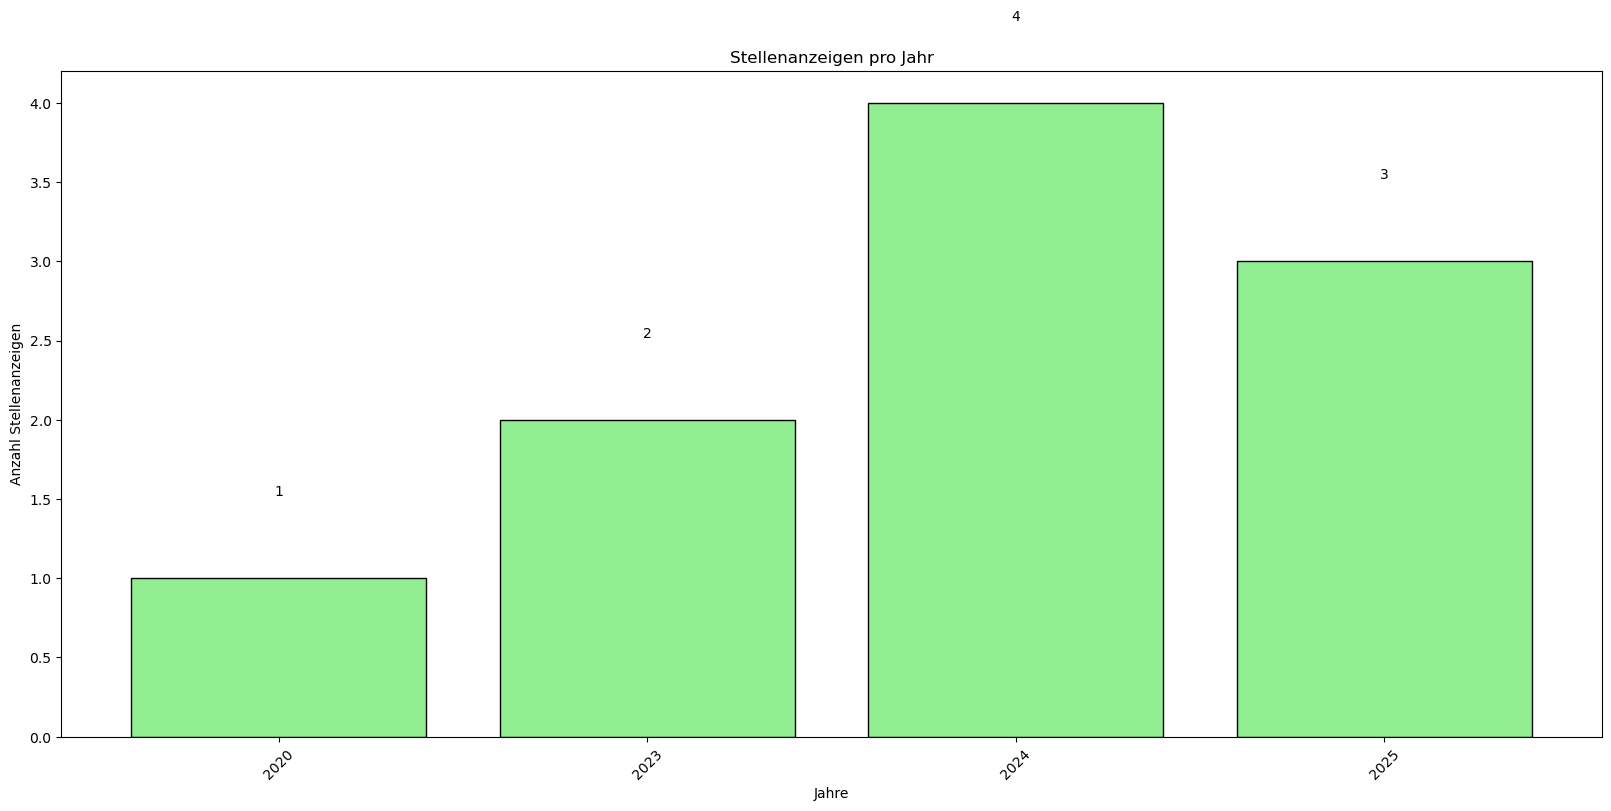

In [43]:
# Stellenanzeigen pro Jahr
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
xyears = np.arange(len(years))
yyears = [year_counts[year] for year in years]
ax = axes
bartwo = ax.bar(xyears, yyears, color='lightgreen', edgecolor='black')
for rect in bartwo:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), ha='center', va='bottom')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Jahr')
plt.show()

In [45]:
# Verteilung nach einzelnen Stellenbezeichnungen (sind als Liste in Variable pfp)
counter_gen = []
counter_kh = []
counter_ap = []
counter_ki = []
counter_gen_gesamt = 0
counter_kh_gesamt = 0
counter_ap_gesamt = 0
counter_ki_gesamt = 0
stellen_full_gen = []
stellen_full_kh = []
stellen_full_ap = []
stellen_full_ki = []
for c_pfp in pfp_gen:
    counter_gen.append([c_pfp, 0])
for c1_pfp in pfp_kh:
    counter_kh.append([c1_pfp, 0])
for c2_pfp in pfp_ap:
    counter_ap.append([c2_pfp, 0])
for c3_pfp in pfp_ki:
    counter_ki.append([c3_pfp, 0])
read_counter = len(read)
for p in range(len(pfp_kh)):
    for n in range(len(read)):
        if re.search('.*'+pfp_kh[p]+'.*', read[n]["full_text"], flags=re.M|re.I):
            if re.search('.*'+pfp_ki[p]+'.*', read[n]["full_text"], flags=re.M|re.I): 
                counter_ki[p][1] += 1
                counter_ki_gesamt += 1
                stellen_full_ki.append([read[n]["date"], read[n]["full_text"]])
                read[n] = {"date": "a", "full_text": "a"}
            else:
                counter_kh[p][1] += 1
                counter_kh_gesamt += 1
                stellen_full_kh.append([read[n]["date"], read[n]["full_text"]])
                read[n] = {"date": "a", "full_text": "a"}
for q in range(len(pfp_ap)):
    for o in range(len(read)):
        if re.search('.*'+pfp_ap[q]+'.*', read[o]["full_text"], flags=re.M|re.I): 
           counter_ap[q][1] += 1
           counter_ap_gesamt += 1
           stellen_full_ap.append([read[o]["date"], read[o]["full_text"]])
           read[o] = {"date": "a", "full_text": "a"}
for l in range(len(pfp_gen)):
    for m in range(len(read)):
        if re.search('.*'+pfp_gen[l]+'.*', read[m]["full_text"], flags=re.M|re.I):
            counter_gen[l][1] += 1
            counter_gen_gesamt += 1
            stellen_full_gen.append([read[m]["date"], read[m]["full_text"]])
            read[m] = {"date": "a", "full_text": "a"}
del read
for cb in range(len(pfp_gen)):
    try:
        prozent = counter_gen[cb][1] / read_counter  * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_gen[cb][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_gen[cb][0]+' ('+str(round(prozent, 2))+' %)')
for cc in range(len(pfp_kh)):
    try:
        prozent = counter_kh[cc][1] / read_counter * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_kh[cc][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_kh[cc][0]+' ('+str(round(prozent, 2))+' %)')
for cd in range(len(pfp_ap)):
    try:
        prozent = counter_ap[cd][1]/read_counter*100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_ap[cd][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_ap[cd][0]+' ('+str(round(prozent, 2))+' %)')
for ce in range(len(pfp_ki)):
    try:
        prozent = counter_ki[ce][1] / read_counter  * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_ki[ce][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_ki[ce][0]+' ('+str(round(prozent, 2))+' %)')
print('Insgesamt '+str(counter_gen_gesamt)+' Stellenanzeigen für generalistische Berufsbezeichnungen ('+str(round(counter_gen_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_kh_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Akutpflege ('+str(round(counter_kh_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_ap_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Altenpflege ('+str(round(counter_ap_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_ki_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Kinderkrankenpflege ('+str(round(counter_ki_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')

[['2020-08-01', 'abcAltenpflegerjhk'], ['2025-01-03', 'abcAltenpflegerinabc'], ['2024-06-07', '123Altenpflegefachkraft123']]
Insgesamt 1 Stellenanzeigen für Berufsbezeichnung Pflegefachperson (10.0 %)
Insgesamt 1 Stellenanzeigen für Berufsbezeichnung Pflegefachfrau (10.0 %)
Insgesamt 1 Stellenanzeigen für Berufsbezeichnung Pflegefachmann (10.0 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Pflegefachkraft (0.0 %)
Insgesamt 1 Stellenanzeigen für Berufsbezeichnung Krankenschwester (10.0 %)
Insgesamt 2 Stellenanzeigen für Berufsbezeichnung Krankenpfleger (20.0 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Krankenpflegefachperson (0.0 %)
Insgesamt 2 Stellenanzeigen für Berufsbezeichnung Altenpfleger (20.0 %)
Insgesamt 1 Stellenanzeigen für Berufsbezeichnung Altenpflegefachkraft (10.0 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Altenpflegefachperson (0.0 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Kinderkrankenschwester (0.0 %)
Insgesamt 1 Stellenanzeigen für 

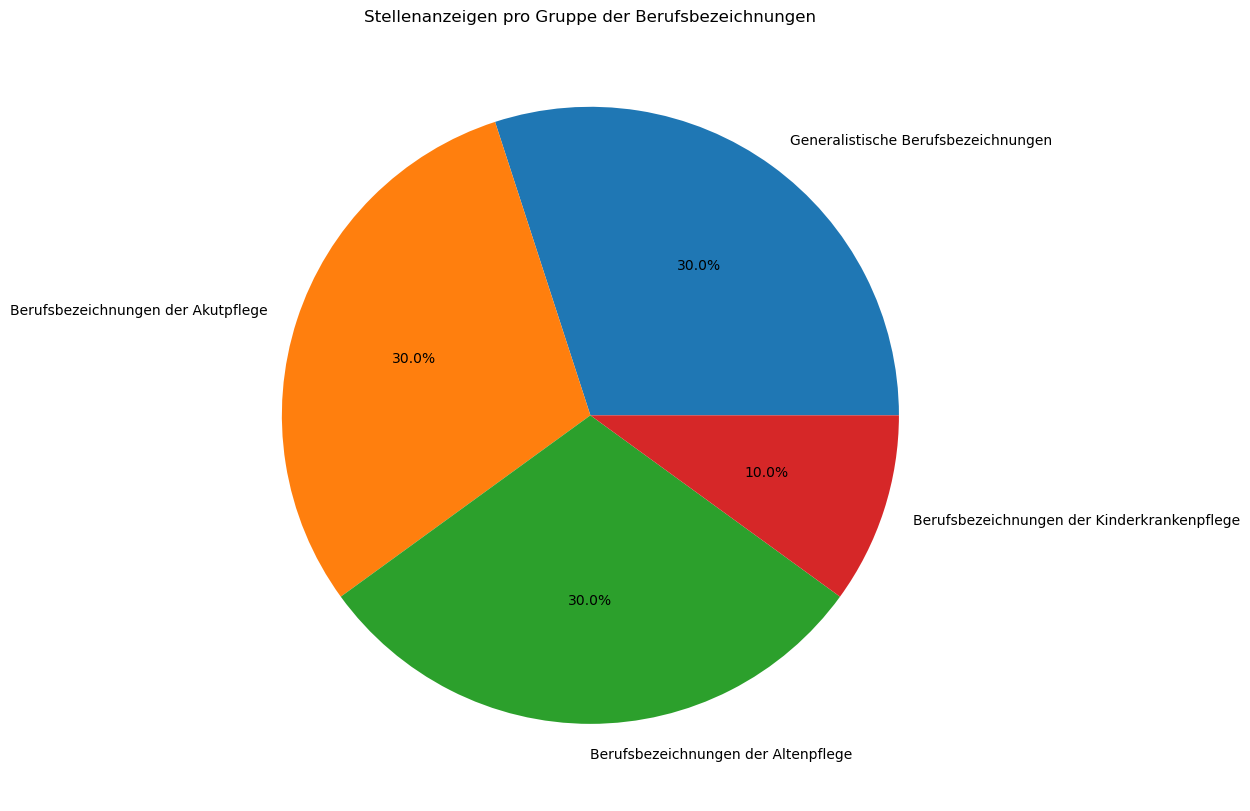

In [21]:
# Diagramm Plotten --> Torte --> Anzahl aller Stellenanzeigen nach Berufsgruppe (Gen(KH/AP))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
gpiesizes = [counter_gen_gesamt, counter_kh_gesamt, counter_ap_gesamt, counter_ki_gesamt]
gpielabels = ['Generalistische Berufsbezeichnungen', 'Berufsbezeichnungen der Akutpflege', 'Berufsbezeichnungen der Altenpflege', 'Berufsbezeichnungen der Kinderkrankenpflege']
ax = axes
ax.pie(gpiesizes, labels=gpielabels, autopct='%1.1f%%')
ax.set_title('Stellenanzeigen pro Gruppe der Berufsbezeichnungen')
plt.show()

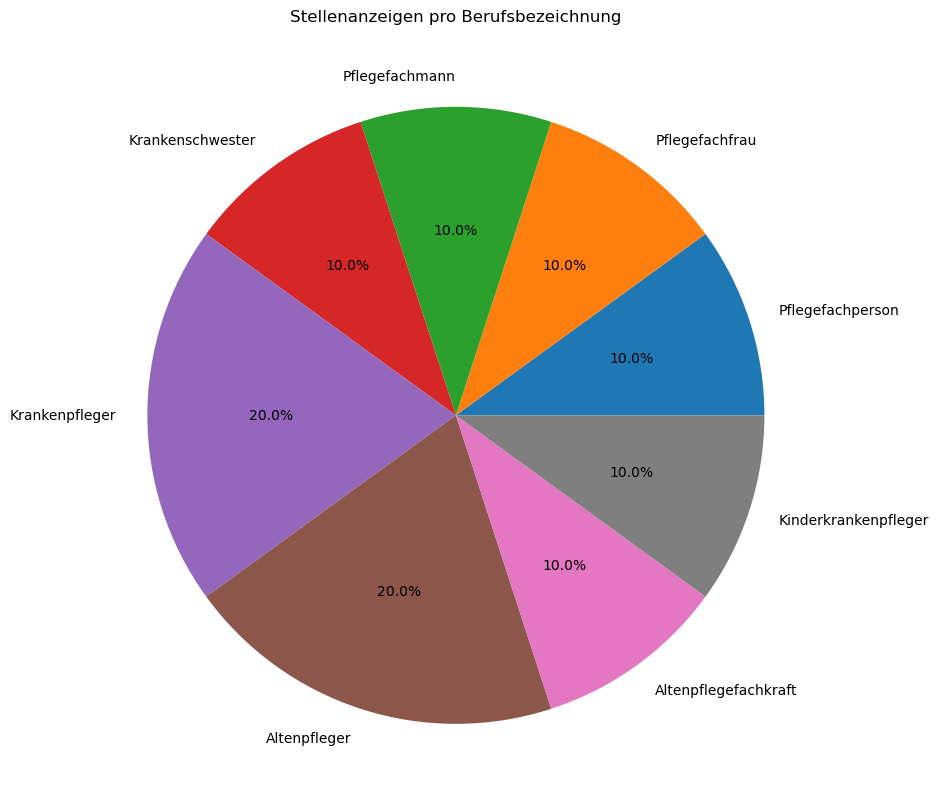

In [23]:
# Diagramm plotten --> Torte --> Anzahl aller Stellenanzeigen nach Berufsbezeichnung
bpiesizes = []
bpielabels = []
for csi in range(len(counter_gen)):
    if counter_gen[csi][1] > 0:
        bpiesizes.append(counter_gen[csi][1])
        bpielabels.append(counter_gen[csi][0])
for csio in range(len(counter_kh)):
    if counter_kh[csio][1] > 0:
        bpiesizes.append(counter_kh[csio][1])
        bpielabels.append(counter_kh[csio][0])
for csih in range(len(counter_ap)):
    if counter_ap[csih][1] > 0:
        bpiesizes.append(counter_ap[csih][1])
        bpielabels.append(counter_ap[csih][0])
for csii in range(len(counter_ki)):
    if counter_ki[csii][1] > 0:
        bpiesizes.append(counter_ki[csii][1])
        bpielabels.append(counter_ki[csii][0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]})
ax = axes
ax.pie(bpiesizes, labels=bpielabels, autopct='%1.1f%%')
ax.set_title('Stellenanzeigen pro Berufsbezeichnung')
plt.show()

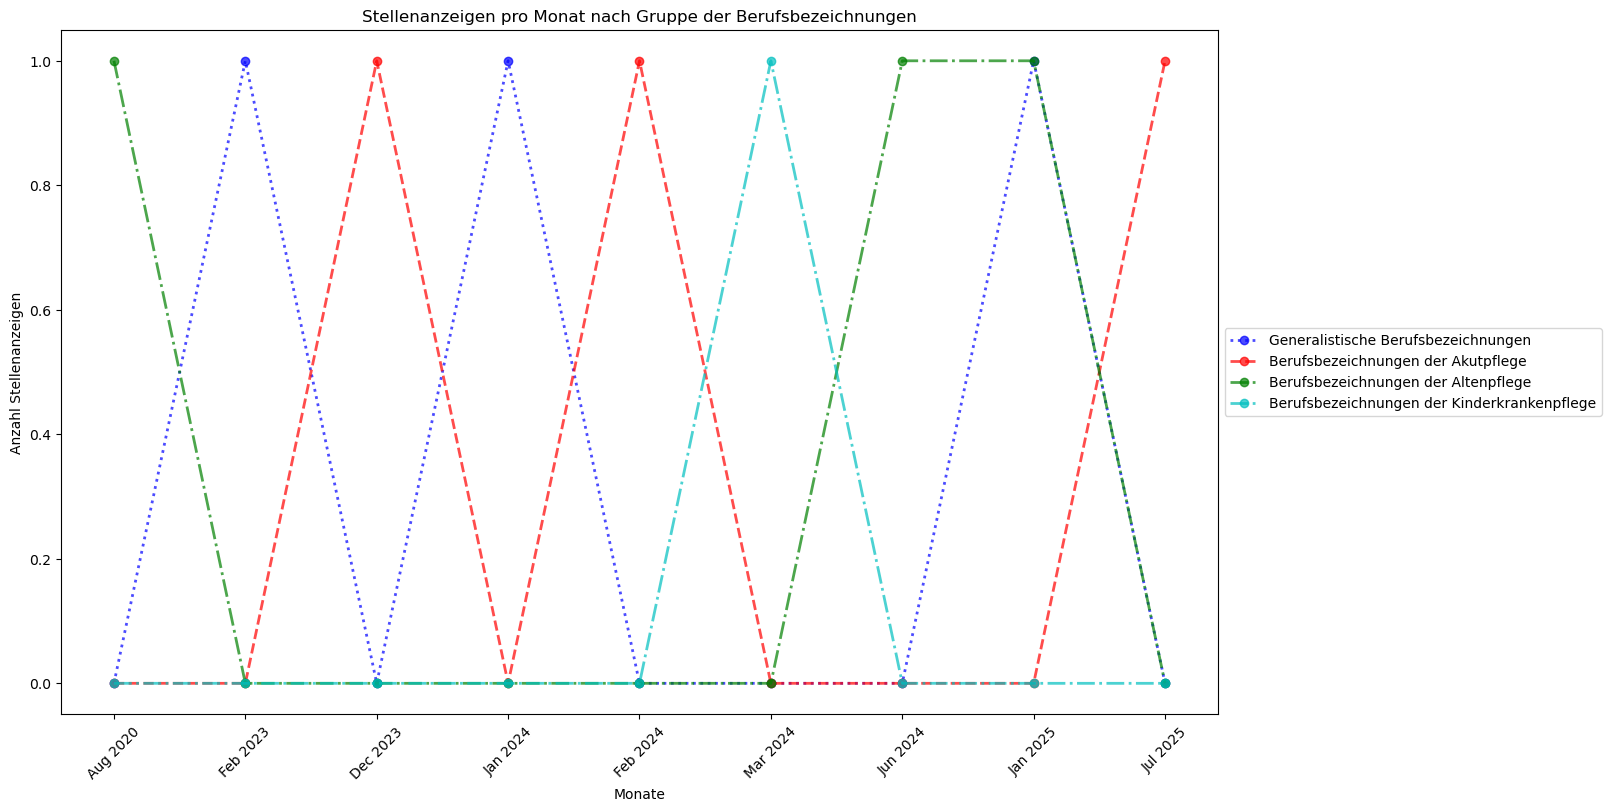

In [49]:
# Pro Monat nach Gruppe als Kurve
month_counts_gen = {month: 0 for month in months}
month_counts_kh = {month: 0 for month in months}
month_counts_ap = {month: 0 for month in months}
month_counts_ki = {month: 0 for month in months}
year_counts_gen = {year: 0 for year in years}
year_counts_kh = {year: 0 for year in years}
year_counts_ap = {year: 0 for year in years}
year_counts_ki = {year: 0 for year in years}
for item in range(len(stellen_full_gen)):
    ts = datetime.strptime(stellen_full_gen[item][0], "%Y-%m-%d")   
    month_counts_gen[(ts.year, ts.month)] = month_counts_gen.get((ts.year, ts.month), 0) + 1
    year_counts_gen[ts.year] = year_counts_gen.get(ts.year, 0) + 1
for itemt in range(len(stellen_full_kh)):
    ts = datetime.strptime(stellen_full_kh[itemt][0], "%Y-%m-%d")   
    month_counts_kh[(ts.year, ts.month)] = month_counts_kh.get((ts.year, ts.month), 0) + 1
    year_counts_kh[ts.year] += 1
for itemk in range(len(stellen_full_ap)):
    ts = datetime.strptime(stellen_full_ap[itemk][0], "%Y-%m-%d")   
    month_counts_ap[(ts.year, ts.month)] = month_counts_ap.get((ts.year, ts.month), 0) + 1
    year_counts_ap[ts.year] += 1    
for iteml in range(len(stellen_full_ki)):
    ts = datetime.strptime(stellen_full_ki[iteml][0], "%Y-%m-%d")   
    month_counts_ki[(ts.year, ts.month)] = month_counts_ki.get((ts.year, ts.month), 0) + 1
    year_counts_ki[ts.year] += 1   
ymonths_gen = list(month_counts_gen.values())
ymonths_kh = list(month_counts_kh.values())
ymonths_ap = list(month_counts_ap.values())
ymonths_ki = list(month_counts_ki.values())
yyears_gen = list(year_counts_gen.values())
yyears_kh = list(year_counts_kh.values())
yyears_ap = list(year_counts_ap.values())
yyears_ki = list(year_counts_ki.values())
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]})
ax = axes #2, 0
ax.plot(xmonths, ymonths_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xmonths, ymonths_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xmonths, ymonths_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xmonths, ymonths_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Monat nach Gruppe der Berufsbezeichnungen')
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
plt.show()

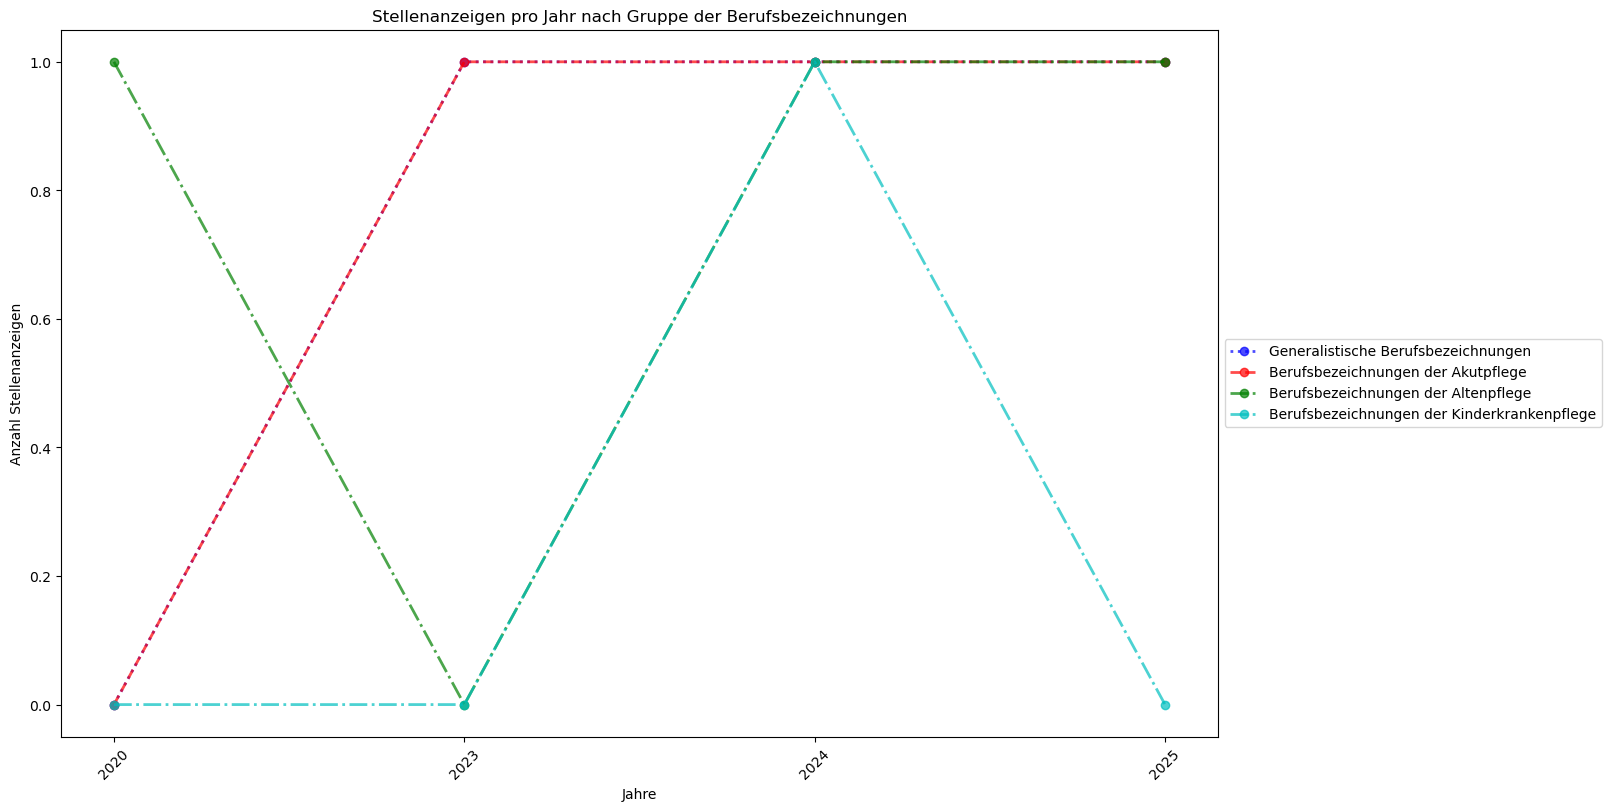

In [51]:
# Jetzt noch pro Jahr + Art
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes # 2, 1
ax.plot(xyears, yyears_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xyears, yyears_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xyears, yyears_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xyears, yyears_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Jahr nach Gruppe der Berufsbezeichnungen')
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
plt.show()

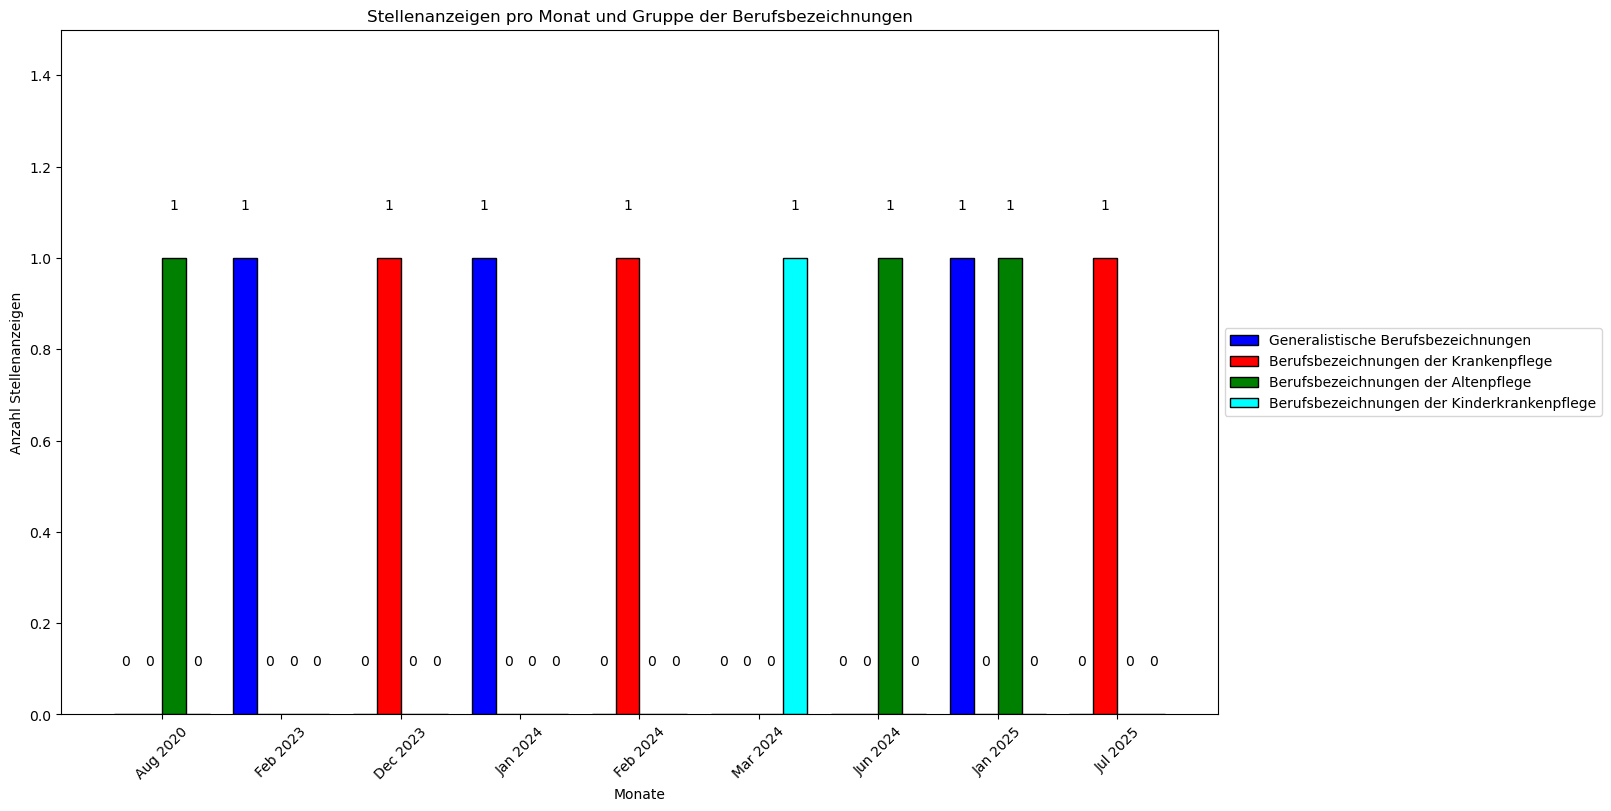

In [53]:
# Stellenanzeigen pro Monat/Jahr nach Gruppe als Bar Chart (statt Kurve)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes # 3, 0
xmonths = np.arange(len(month_labels))
bar_width = 0.2
barthree = ax.bar(xmonths - 1.5 * bar_width, ymonths_gen, bar_width, color='blue', edgecolor='black', label='Generalistische Berufsbezeichnungen')
for rect in barthree:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barfour = ax.bar(xmonths - 0.5 * bar_width, ymonths_kh, bar_width, color='red', edgecolor='black', label='Berufsbezeichnungen der Krankenpflege')
for rect in barfour:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barfive = ax.bar(xmonths + 0.5 * bar_width, ymonths_ap, bar_width, color='green', edgecolor='black', label='Berufsbezeichnungen der Altenpflege')
for rect in barfive:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barsix = ax.bar(xmonths + 1.5 * bar_width, ymonths_ki, bar_width, color='cyan', edgecolor='black', label='Berufsbezeichnungen der Kinderkrankenpflege')
for rect in barsix:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.margins(y=0.5)
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Monat und Gruppe der Berufsbezeichnungen')
plt.show()

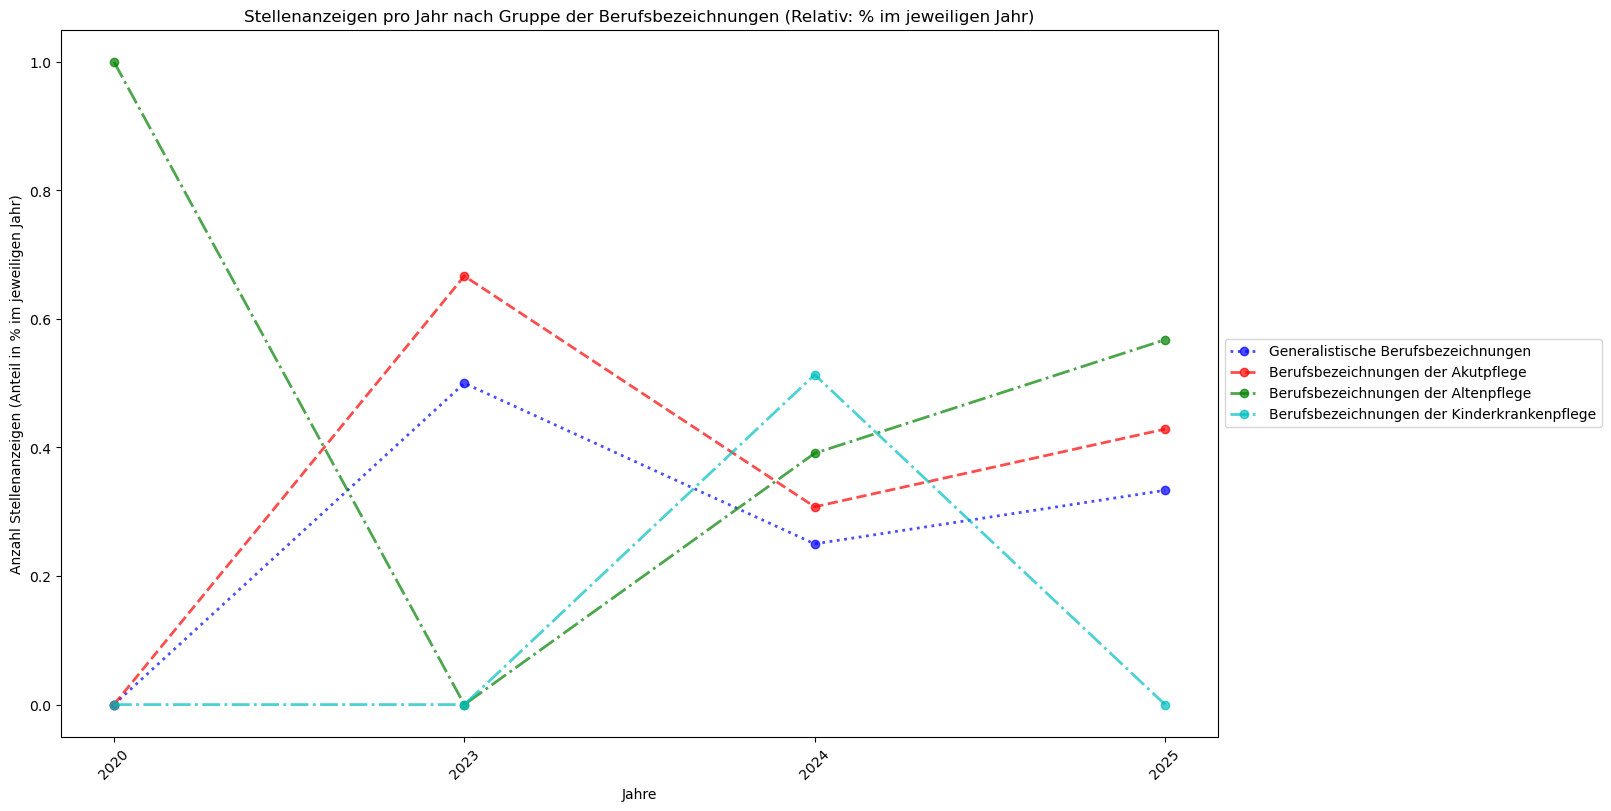

In [55]:
# ToDo: Bar/Kurve: Stellenanzeigen pro Gruppe pro Jahr/Monat - relativ
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
rel_yyears_gen = yyears_gen
rel_yyears_kh = yyears_kh
rel_yyears_ap = yyears_ap
rel_yyears_ki = yyears_ki
for c_yg in range(len(yyears_gen)):
    rel_yyears_gen[c_yg] = yyears_gen[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_kh[c_yg] = yyears_kh[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_ap[c_yg] = yyears_ap[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_ki[c_yg] = yyears_ki[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
ax.plot(xyears, rel_yyears_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xyears, rel_yyears_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xyears, rel_yyears_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xyears, rel_yyears_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Jahr nach Gruppe der Berufsbezeichnungen (Relativ: % im jeweiligen Jahr)')
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen (Anteil in % im jeweiligen Jahr)')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
plt.show()

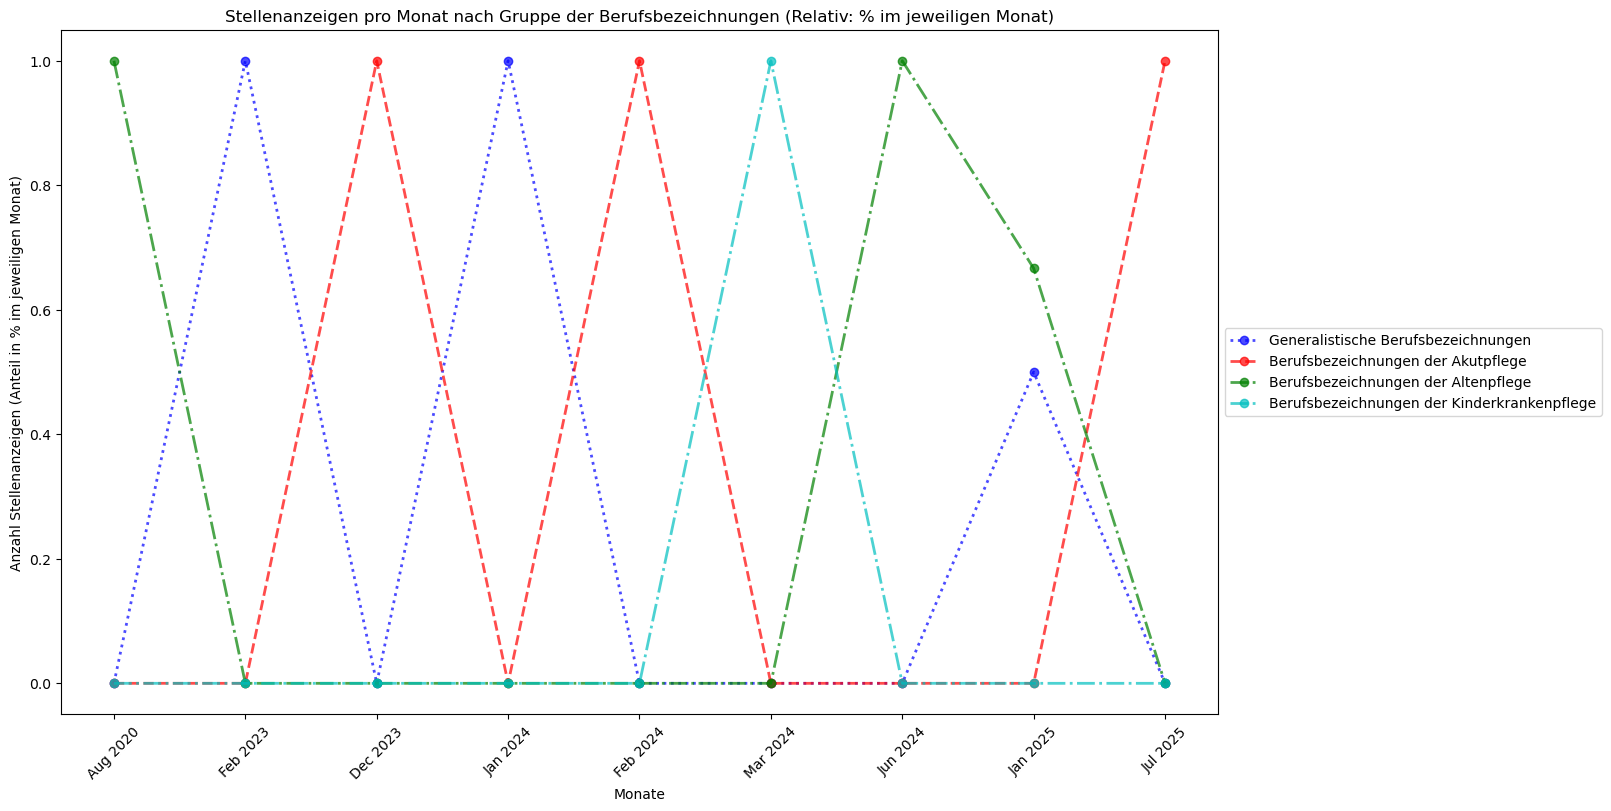

In [57]:
# Pro Monat
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
rel_ymonths_gen = ymonths_gen
rel_ymonths_kh = ymonths_kh
rel_ymonths_ap = ymonths_ap
rel_ymonths_ki = ymonths_ki
del c_yg
for c_yg in range(len(ymonths_gen)):
    rel_ymonths_gen[c_yg] = ymonths_gen[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_kh[c_yg] = ymonths_kh[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_ap[c_yg] = ymonths_ap[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_ki[c_yg] = ymonths_ki[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
ax.plot(xmonths, rel_ymonths_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xmonths, rel_ymonths_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xmonths, rel_ymonths_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xmonths, rel_ymonths_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Monat nach Gruppe der Berufsbezeichnungen (Relativ: % im jeweiligen Monat)')
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen (Anteil in % im jeweiligen Monat)')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
plt.show()

In [ ]:
# ToDo: Hochschulisch qualifizierte rausfiltern und darstellen